In [2]:
import numpy as np
import matplotlib.pyplot as plt
from train import get_parser
from ssd.config.defaults import cfg
from ssd.data.build import make_data_loader
from vizer.draw import draw_boxes
%matplotlib inline
from matplotlib import pyplot as plt

import cv2
from urllib.request import urlopen
from albumentations import (
    BboxParams,
    HorizontalFlip,
    VerticalFlip,
    Resize,
    CenterCrop,
    RandomCrop,
    Crop,
    Compose
)
np.random.seed(0)
#test the new aug. From the paper about data augmentation
from ssd.data.transforms.autoaugment_utils import *

In [3]:
config_path = "configs/train_waymo_Copy1.yaml"
cfg.merge_from_file(config_path)
cfg.freeze()
cfg.INPUT.PIXEL_MEAN

[123, 117, 104]

In [4]:
#Do not need to run
# data_loader = make_data_loader(cfg, is_train=True)
# if isinstance(data_loader, list):
#     print(list)
#     data_loader = data_loader[0]
# dataset = data_loader.dataset
# indices = list(range(len(dataset)))
#np.random.shuffle(indices)

In [5]:
# idx = indices[1]
# image = dataset._read_image(idx)
# boxes, labels = dataset.get_annotation(idx)
# image = draw_boxes(
#     image, boxes, labels, class_name_map=dataset.class_names
# )
# plt.figure(figsize=(20, 12))
# plt.imshow(image)
#plt.imsave("visualization.png", image)
#print("Saved the image to visualization.png")

In [6]:
#The codes above is designed by the TA of tdt4265
#The flowing part is designed by Xiaoyu to understand the data augmentations

In [7]:
from ssd.data.transforms.transforms import *
from torchvision import transforms

In [8]:
#Dive into the data loading
import pathlib
from PIL import Image
import json

def _read_image(index):
    data_dir = "datasets/waymo"
    data_dir =pathlib.Path(data_dir)
    image_id = index
    image_path = data_dir.joinpath("images").joinpath(f"{image_id}.jpg")
    image = Image.open(str(image_path)).convert("RGB")
    image = np.array(image)
    return image
def _get_annotation(image_id,labels):
    label = labels[image_id]
    bbox_key = "bounding_boxes"
    if bbox_key not in label:
        bbox_key = "bboxes"
    boxes = np.zeros((len(label[bbox_key]), 4), dtype=np.float32)
    labels = np.zeros((len(label[bbox_key])), dtype=np.int64)
    for idx, bounding_box in enumerate(label[bbox_key]):
        box = [
            bounding_box["xmin"],
            bounding_box["ymin"],
            bounding_box["xmax"],
            bounding_box["ymax"]]
        boxes[idx] = box
        labels[idx] = bounding_box["label_id"]
    # SSD use label 0 as the background. Therefore +1
    labels = labels + 1
    return boxes, labels
def read_labels(label_path):
    assert label_path.is_file(), \
        f"Did not find label file: {label_path.absolute()}"
    with open(label_path, "r") as fp:
        labels = json.load(fp)
    labels_processed = {}
    for label in labels:
        image_id = label["image_id"]
        labels_processed[image_id] = label
    return labels_processed

In [9]:
#covnert x_min,y_min,x_max,y_max to min_y, min_x, max_y, max_x
def trans_coor_boxes(box_original):
#covnert x_min,y_min,x_max,y_max to min_y, min_x, max_y, max_x
    box_trans=np.zeros(box_original.shape)
    box_trans[:,0]=box_original[:,1]
    box_trans[:,1]=box_original[:,0]
    box_trans[:,2]=box_original[:,3]
    box_trans[:,3]=box_original[:,2]
    return box_trans
    
    

In [19]:
#get the image '1.jpg' and relating box and label
idx = 1
print(idx)
image_test=_read_image(idx)
data_dir = "datasets/waymo"
data_dir =pathlib.Path(data_dir)
label_total=read_labels(data_dir.joinpath("labels.json"))
label_test=_get_annotation(idx,label_total)
box_test=label_test[0] 
label_test = label_test[1]
class_test='__background__', 'vehicle', 'person', 'sign', 'cyclist'

1


In [11]:
#print('image_test',image_test)
#print('label_test',label_test)
#print('box_test',box_test)

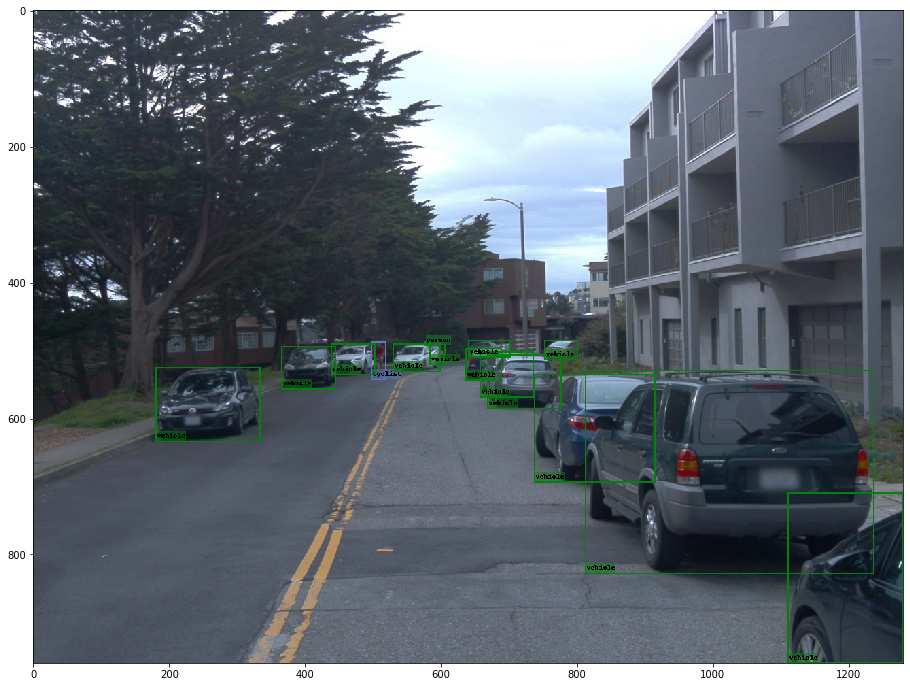

In [12]:
#Show the original version of the '1.jpg'
image_show = draw_boxes(
    image_test, box_test, label_test, class_name_map=class_test)
plt.figure(figsize=(20, 12))
plt.imshow(image_show)

In [20]:
#For the paper about data augmentation
#This is the data augmentation used in Xiaoyu's code
t1=ConvertFromInts()
t2=colorJitter()
t3=RandomErasing()
#t2=PhotometricDistort()
t4=Expand(cfg.INPUT.PIXEL_MEAN)
t5=RandomSampleCrop()
t6=RandomMirror()
t7=ToPercentCoords()
t8=Resize(cfg.INPUT.IMAGE_SIZE)
t9=SubtractMeans(cfg.INPUT.PIXEL_MEAN)
t10=ToPILImage()
t_absolute_coor=ToAbsoluteCoords()
trans_pol=DataAaugmentationPolicy(cfg.DATASETS.AUG_POLICY)

In [21]:
img,box,label=t7(image_test,box_test,label_test)

In [22]:
img,box,label=trans_pol(image_test,box_test,label_test)

In [25]:
cfg.DATASETS.AUG_POLICY

'v0'

In [23]:
#Convert_to_absolute_corrdinate_for_plot
img,box,label=t_absolute_coor(img,box,label)

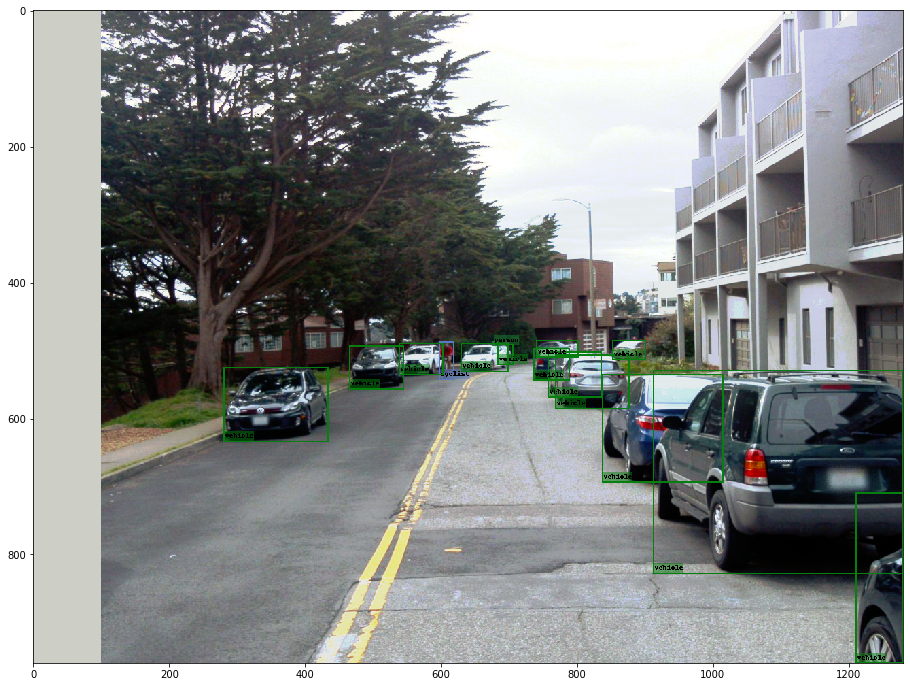

In [24]:
image_show = draw_boxes(
    img.astype('uint8'), box, label_test, class_name_map=class_test
)
plt.figure(figsize=(20, 12))
plt.imshow(image_show)

In [17]:
#cuz the lib need the percentage coords.
img,box,label=t7(image_test,box_test,label_test)
#Do the audmentation
img, box = distort_image_with_autoaugment(img, trans_coor_boxes(box), 'v1')
#exchange the x_y_corridniates
box=trans_coor_boxes(box)
#Convert_to_absolute_corrdinate_for_plot
img,box,label=t_absolute_coor(img,box,label)

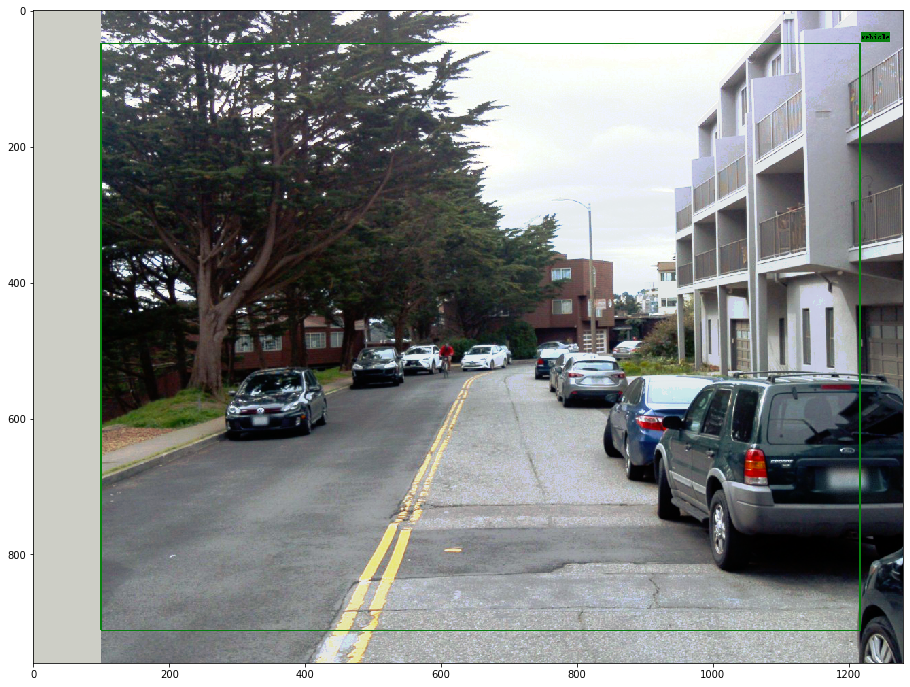

In [18]:
image_show = draw_boxes(
    img.astype('uint8'), box, label_test, class_name_map=class_test
)
plt.figure(figsize=(20, 12))
plt.imshow(image_show)

In [1]:
img,box,label=t7(img,box,label)
img, box = distort_image_with_autoaugment(img, trans_coor_boxes(box), 'v1')
box=trans_coor_boxes(box)
img,box,label=t_absolute_coor(img,box,label)

NameError: name 't7' is not defined

In [ ]:
image_show = draw_boxes(
    img.astype('uint8'), box, label_test, class_name_map=class_test
)
plt.figure(figsize=(20, 12))
plt.imshow(image_show)

In [ ]:
img,box,label=t7(img,box,label)
img, box = distort_image_with_autoaugment(img, trans_coor_boxes(box), 'v1')
box=trans_coor_boxes(box)
img,box,label=t_absolute_coor(img,box,label)

In [ ]:
image_show = draw_boxes(
    img.astype('uint8'), box, label_test, class_name_map=class_test
)
plt.figure(figsize=(20, 12))
plt.imshow(image_show)

In [ ]:
img,box,label=t7(img,box,label)
img, box = distort_image_with_autoaugment(img, trans_coor_boxes(box), 'v1')
box=trans_coor_boxes(box)
img,box,label=t_absolute_coor(img,box,label)

In [ ]:
#12nd April. Try the new lib called  albumentations
%matplotlib inline
from urllib.request import urlopen
import os

import numpy as np
import cv2
from matplotlib import pyplot as plt

from albumentations import (
    BboxParams,
    HorizontalFlip,
    VerticalFlip,
    Resize,
    CenterCrop,
    RandomCrop,
    Crop,
    Compose
)
def download_image(url):
    data = urlopen(url).read()
    data = np.frombuffer(data, np.uint8)
    image = cv2.imdecode(data, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [ ]:
# Functions to visualize bounding boxes and class labels on an image. 
# Based on https://github.com/facebookresearch/Detectron/blob/master/detectron/utils/vis.py

BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)


def visualize_bbox(img, bbox, class_id, class_idx_to_name, color=BOX_COLOR, thickness=2):
    #x_min, y_min, w, h = bbox
    x_min, y_min, x_max, y_max = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_max), int(y_min), int(y_max)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img


def visualize(annotations, category_id_to_name):
    img = annotations['image'].copy()
    for idx, bbox in enumerate(annotations['bboxes']):
        img = visualize_bbox(img, bbox, annotations['category_id'][idx], category_id_to_name)
    plt.figure(figsize=(20, 12))
    plt.imshow(img)

In [ ]:
def get_aug(aug, min_area=0., min_visibility=0.):
    return Compose(aug, bbox_params=BboxParams(format='pascal_voc', min_area=min_area, 
                                               min_visibility=min_visibility, label_fields=['category_id']))


In [ ]:
bbox=[]
for i in box_test:
    bbox.append(list(i))


In [ ]:
# Annotations for image 386298 from COCO http://cocodataset.org/#explore?id=386298
#annotations = {'image': image_test, 'bboxes': [[366.7, 80.84, 132.8, 181.84], [5.66, 138.95, 147.09, 164.88]], 'category_id': [2, 3]}
annotations = {'image': image_test, 'bboxes': bbox, 'category_id':  list(label_test)}

category_id_to_name= {0:'__background__',
                      1:'vehicle',
                      2:'person',
                      3:'sign',
                      4:'cyclist'}

In [ ]:
visualize(annotations, category_id_to_name)

In [ ]:
p0=policy_v0()

In [ ]:
print(p0)

In [ ]:
print(img.shape)
print(box.shape)

In [ ]:
image_show = draw_boxes(
    img.astype('uint8'), box, label_test, class_name_map=class_test
)
plt.figure(figsize=(20, 12))
plt.imshow(image_show)

In [ ]:
aug = get_aug([VerticalFlip(p=1)])

In [ ]:
augmented = aug(**annotations)

In [ ]:
visualize(augmented, category_id_to_name)

In [ ]:
aug = get_aug([HorizontalFlip(p=1)])
augmented = aug(**annotations)
visualize(augmented, category_id_to_name)

In [ ]:
aug = get_aug([CenterCrop(p=1, height=300, width=300)])
augmented = aug(**annotations)
visualize(augmented, category_id_to_name)

In [ ]:
# Compose filters bounding boxes and returns
# only those boxes whose visibility after transformation is above the threshold.
aug = get_aug([CenterCrop(p=1, height=300, width=300)], min_visibility=0.3)
augmented = aug(**annotations)
visualize(augmented, category_id_to_name)

# Visibility of the transformed bbox for `dog` is about 0.25 (that means that
# the area of the transformed bbox is about 25% of the area of the original bbox),
# so it will be removed
# Visibility of the transformed bbox for `cat` is about 0.36,
# so it will be kept.

In [ ]:
#Dive into different Data transforms

In [ ]:
#This is the data augmentation used in Xiaoyu's code
t1=ConvertFromInts()
t2=colorJitter()
t3=RandomErasing()
#t2=PhotometricDistort()
t4=Expand(cfg.INPUT.PIXEL_MEAN)
t5=RandomSampleCrop()
t6=RandomMirror()
t7=ToPercentCoords()
t8=Resize(cfg.INPUT.IMAGE_SIZE)
t9=SubtractMeans(cfg.INPUT.PIXEL_MEAN)
t10=ToPILImage()

In [ ]:
#t1=ConvertFromInts()
img,box,label=t1(image_test,box_test,label_test)

In [ ]:
# print('img',img)
# print('box',box)
# print('label',label)

In [ ]:
#Show the pic
image_show = draw_boxes(
    img.astype('uint8'), box, label, class_name_map=class_test
)
plt.figure(figsize=(20, 12))
plt.imshow(image_show)

In [ ]:
#t2 is colorJitter()
img,box,label=t2(img,box,label) 

In [ ]:

#print('img',img)
# print('box',box)
# print('label',label)

In [ ]:
#Show the pic
image_show = draw_boxes(
    img.astype('uint8'), box, label, class_name_map=class_test
)
plt.figure(figsize=(20, 12))
plt.imshow(image_show)

In [ ]:
#t3 is Expand
img,box,label=t3(img,box,label) 

In [ ]:
# print('img',img)
# print('box',box)
# print('label',label)

In [ ]:
#Show the pic
image_show = draw_boxes(
    img.astype('uint8'), box, label, class_name_map=class_test
)
plt.figure(figsize=(20, 12))
plt.imshow(image_show)

In [ ]:
#t4=RandomSampleCrop()
img,box,label=t4(img,box,label)

In [ ]:
# print('img',img)
# print('box',box)
# print('label',label)

In [ ]:
#Show the pic
image_show = draw_boxes(
    img.astype('uint8'), box, label, class_name_map=class_test
)
plt.figure(figsize=(20, 12))
plt.imshow(image_show)

In [ ]:
#t5=RandomMirror()
img,box,label=t5(img,box,label)

In [ ]:
# print('img',img)
# print('box',box)
# print('label',label)

In [ ]:
#Show the pic
image_show = draw_boxes(
    img.astype('uint8'), box, label, class_name_map=class_test
)
plt.figure(figsize=(20, 12))
plt.imshow(image_show)

In [ ]:
#t6=ToPercentCoords(),
img,box,label=t6(img,box,label)

In [ ]:
#Show the pic
image_show = draw_boxes(
    img.astype('uint8'), box, label, class_name_map=class_test
)
plt.figure(figsize=(20, 12))
plt.imshow(image_show)

In [ ]:
#t7=Resize(cfg.INPUT.IMAGE_SIZE),
img,box,label=t7(img,box,label)

In [ ]:
#Show the pic
image_show = draw_boxes(
    img.astype('uint8'), box, label, class_name_map=class_test
)
plt.figure(figsize=(20, 12))
plt.imshow(image_show)

In [ ]:
#t8=SubtractMeans(cfg.INPUT.PIXEL_MEAN),
img,box,label=t8(img,box,label)

In [ ]:
#Show the pic
image_show = draw_boxes(
    img.astype('uint8'), box, label, class_name_map=class_test
)
plt.figure(figsize=(20, 12))
plt.imshow(image_show)

In [ ]:
#t9=SubtractMeans(cfg.INPUT.PIXEL_MEAN),
img,box,label=t9(img,box,label)

In [ ]:
#Show the pic
image_show = draw_boxes(
    img.astype('uint8'), box, label, class_name_map=class_test
)
plt.figure(figsize=(20, 12))
plt.imshow(image_show)

In [ ]:
#Try to show the box_location:
t_absolute_coor=ToAbsoluteCoords()

In [ ]:
img,box,label=t_absolute_coor(img,box,label)

In [ ]:
#Show the pic
image_show = draw_boxes(
    img.astype('uint8'), box, label, class_name_map=class_test
)
plt.figure(figsize=(20, 12))
plt.imshow(image_show)